In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install required Packages**

In [ ]:
!pip3 install wfdb pytorch_forecasting

In [ ]:
import pandas as pd
import numpy as np
import ast
import wfdb
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from sklearn.model_selection import train_test_split
import torch
import os

# Utility Functions

In [ ]:

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        #print(data)
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def process_patient_data(patient_id, age,sex,ecg_id, filename_lr, path):
    """
    Load ECG waveform data for a single patient and combine with their static information.

    Args:
        patient_id (int): The ID of the patient.
        age (int): The age of the patient.
        filename_lr (str): Path to the patient's waveform data file (low resolution).
        path (str): Base path to the waveform data files.

    Returns:
        pd.DataFrame: A DataFrame containing ECG waveform data and static info for the patient.
    """
    full_path = os.path.join(path, filename_lr)

    try:
        # Attempt to load the waveform data
        signal, meta = wfdb.rdsamp(full_path)
    except (FileNotFoundError, ValueError):
        # Return empty DataFrame if file is not found or invalid
        return pd.DataFrame()

    # Create a DataFrame for the time-series ECG data
    num_timesteps, num_leads = signal.shape
    time_idx = np.arange(num_timesteps)
    ecg_df = pd.DataFrame(signal, columns=[f"lead_{i}" for i in range(num_leads)])
    ecg_df["time_idx"] = time_idx

    # Add static patient information
    ecg_df["patient_id"] = patient_id
    ecg_df["age"] = age
    ecg_df["sex"] = sex
    ecg_df["ecg_id"] = ecg_id

    # Reorder columns for clarity
    columns = ["ecg_id","patient_id","time_idx", "age", "sex"] + [f"lead_{i}" for i in range(num_leads)]
    ecg_df = ecg_df[columns]

    return ecg_df


# Read Data

In [ ]:
'''
path='/content/drive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
df = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
#df=df[(df["patient_id"] == 381.0) & (df.index== 693)]
df = df[df['filename_lr'].str.contains(r'^records100/00000')]
# Process all patients
all_patients = []

for _, row in df.iterrows():
    patient_data = process_patient_data(
        patient_id=row["patient_id"],
        ecg_id=row.name,
        age=row["age"],
        sex=row["sex"],
        filename_lr=row["filename_lr"],
        path=path
    )
    all_patients.append(patient_data)

# Combine all patients into a single DataFrame
final_df = pd.concat(all_patients, ignore_index=True)
'''

# Replace 'path_to_your_csv_file' with the actual path to your CSV file in Google Drive
file_path = '/content/drive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records100/processed_ecg_data.csv'

# Read the CSV file
final_df = pd.read_csv(file_path)
(final_df.head())
patient_data=final_df

**Downsample ECG waveform data from 100 Hz to 50 Hz**

In [ ]:
import pandas as pd

# Function to truncate every alternate row and reduce to 500 rows per ECG ID
def reduce_ecg_data(df, target_readings=500):
    # Group by `ecg_id` and truncate each group
    reduced_df = df.groupby("ecg_id").apply(lambda group: group.iloc[:target_readings:2]).reset_index(drop=True)
    return reduced_df

# Apply the function to your dataset
reduced_data = reduce_ecg_data(patient_data, target_readings=1000)

print(f"Original dataset size: {patient_data.shape}")
print(f"Reduced dataset size: {reduced_data.shape}")

def reset_time_index(df):
    df["time_idx"] = df.groupby("ecg_id").cumcount()
    return df

# Apply the function to your dataset
reduced_data = reset_time_index(reduced_data)
patient_data=reduced_data



**Plot the sample ECG data**

In [ ]:
# Select one patient by ecg_id
ecg_id_to_check = 1  # Replace with the ecg_id you want to verify

# Count rows for the selected ecg_id in both datasets
original_count = patient_data[patient_data["ecg_id"] == ecg_id_to_check].shape[0]
reduced_count = reduced_data[reduced_data["ecg_id"] == ecg_id_to_check].shape[0]

print(f"Original data count for ecg_id {ecg_id_to_check}: {original_count}")
print(f"Reduced data count for ecg_id {ecg_id_to_check}: {reduced_count}")
import matplotlib.pyplot as plt

# Function to plot ECG data for one patient
def plot_patient_data(original_df, reduced_df, ecg_id):
    # Filter data for the selected ecg_id
    original_ecg = original_df[original_df["ecg_id"] == ecg_id]
    reduced_ecg = reduced_df[reduced_df["ecg_id"] == ecg_id]

    # Plot the data
    plt.figure(figsize=(12, 6))

    # Plot original data
    plt.subplot(1, 2, 1)
    plt.plot(original_ecg["time_idx"], original_ecg["lead_0"], label="Lead 0")
    plt.title(f"Original Data (ecg_id: {ecg_id}) - {len(original_ecg)} Readings")
    plt.xlabel("Time Index")
    plt.ylabel("Amplitude")
    plt.legend()

    # Plot reduced data
    plt.subplot(1, 2, 2)
    plt.plot(reduced_ecg["time_idx"], reduced_ecg["lead_0"], label="Lead 0", color="orange")
    plt.title(f"Reduced Data (ecg_id: {ecg_id}) - {len(reduced_ecg)} Readings")
    plt.xlabel("Time Index")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
ecg_id_to_plot = 1  # Replace with the ecg_id you want to plot
plot_patient_data(patient_data, reduced_data, ecg_id_to_plot)



# Visualize the Waveform data

In [ ]:
# Plot the lead_0 data over time for the patient
p_df = patient_data[patient_data["ecg_id"]==4]
plt.figure(figsize=(12, 6))
plt.plot(p_df["time_idx"], p_df["lead_0"], label="Lead 0")
plt.title("Lead 0 ECG Signal Over Time", fontsize=14)
plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


**Divide data in to Train, Validation and Test**

In [ ]:
from sklearn.model_selection import train_test_split

unique_ids = patient_data["ecg_id"].unique()
#Step 2: First split into train (80%) and temp (20%) [for val & test]
train_ecg_ids, temp_ecg_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# Step 3: Split temp into validation
val_ecg_ids, test_ecg_ids = train_test_split(temp_ecg_ids, test_size=0.1, random_state=42)

# Step 4: Create DataFrames based on selected ECG_IDs
train_df = patient_data[patient_data["ecg_id"].isin(train_ecg_ids)].copy()
val_df = patient_data[patient_data["ecg_id"].isin(val_ecg_ids)].copy()
test_df = patient_data[patient_data["ecg_id"].isin(test_ecg_ids)].copy()

# Display the shape of the splits
print("Train Data Shape:", train_df.shape)
print("Validation Data Shape:", val_df.shape)
print("Test Data Shape:", test_df.shape)

**Save the testing data to csv to use later for testing model**

In [ ]:
file_path = '/content/drive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records100/test_df.csv'

# Save the DataFrame to CSV
test_df.to_csv(file_path, index=False)

In [ ]:
from pytorch_forecasting.data import TorchNormalizer

target_normalizer = TorchNormalizer(
    method="standard",  # or "robust" for outlier resistance
    transformation=None  # Avoid squashing values with sigmoid/softplus
)

**Creat dataset and dataloader**

In [ ]:
import pandas as pd

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

# Assuming train_df and test_df are created using the provided code:
# train_df = patient_data[patient_data["ecg_id"].isin(train_ids)]
# test_df = patient_data[patient_data["ecg_id"].isin(test_ids)]

max_prediction_length = 200
max_encoder_length = 300

# Define the TimeSeriesDataSet for training
train_tsdataset = TimeSeriesDataSet(
    train_df,  # Training data
    time_idx="time_idx",  # Time index column
    target="lead_0",  # Target column
    group_ids=["ecg_id"],  # Grouping by patient/ecg_id
    max_encoder_length=max_encoder_length,  # Historical data length
    max_prediction_length=max_prediction_length,  # Future prediction length
    static_reals=["age","sex"],  # Static features (empty in this case)
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["lead_0","lead_1","lead_2","lead_3","lead_4","lead_5","lead_6","lead_7","lead_8","lead_9","lead_10","lead_11"],  # Target variable as time-varying
    target_normalizer=GroupNormalizer(groups=["ecg_id"]),
    add_relative_time_idx = True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Define the TimeSeriesDataSet for validation
val_tsdataset = TimeSeriesDataSet(
    val_df,  # Validation data
    time_idx="time_idx",
    target="lead_0",
    group_ids=["ecg_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=["age","sex"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["lead_0","lead_1","lead_2","lead_3","lead_4","lead_5","lead_6","lead_7","lead_8","lead_9","lead_10","lead_11"],
    target_normalizer=GroupNormalizer(groups=["ecg_id"]),
    add_relative_time_idx = True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Define the TimeSeriesDataSet for validation
test_tsdataset = TimeSeriesDataSet(
    test_df,  # Validation data
    time_idx="time_idx",
    target="lead_0",
    group_ids=["ecg_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=["age","sex"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["lead_0","lead_1","lead_2","lead_3","lead_4","lead_5","lead_6","lead_7","lead_8","lead_9","lead_10","lead_11"],
    target_normalizer=GroupNormalizer(groups=["ecg_id"]),
    add_relative_time_idx = True,
    add_target_scales=True,
    add_encoder_length=True,
)

#val_tsdataset = TimeSeriesDataSet.from_dataset(train_tsdataset, patient_data, predict=True, stop_randomization=True)

In [ ]:
# Create dataloaders
train_dataloader = train_tsdataset.to_dataloader(train=True, batch_size=80, num_workers=2,persistent_workers=True)
val_dataloader = val_tsdataset.to_dataloader(train=False, batch_size=50, num_workers=2, drop_last=True)
test_dataloader = test_tsdataset.to_dataloader(train=False, batch_size=5, num_workers=2, drop_last=True)

print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of val_dataloader: {len(val_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")

Length of train_dataloader: 217
Length of val_dataloader: 78
Length of test_dataloader: 87


**Visualize Encoded Data**

In [ ]:
batch = next(iter(train_dataloader))
encoder_cont_np = batch[0]["encoder_cont"][0].cpu().numpy()

print("Shape of encoder_cont:", encoder_cont_np.shape)  # Check shape
print("First 5 rows of encoder_cont:\n", encoder_cont_np[:5])  # Inspect values

Shape of encoder_cont: (300, 19)
First 5 rows of encoder_cont:
 [[-1.18841395e-01 -9.58264470e-01  1.00000000e+00  5.37809245e-02
   2.36069411e-02 -1.72859013e+00 -1.00000000e+00 -5.19680619e-01
  -3.59113604e-01  8.15188810e-02  4.64893073e-01 -3.01779479e-01
  -1.55696064e-01 -1.07598081e-01 -8.61297399e-02 -8.49837810e-02
   1.36966527e-01  1.86417133e-01  1.14275098e-01]
 [-1.18841395e-01 -9.58264470e-01  1.00000000e+00  5.37809245e-02
   2.36069411e-02 -1.72166193e+00 -9.96666670e-01 -6.51738048e-01
  -3.34615499e-01  2.24607527e-01  5.22563756e-01 -4.49021697e-01
  -5.88349402e-02 -7.35975355e-02 -5.94927967e-02 -5.21406159e-02
   1.56587332e-01  1.90091565e-01  1.49636760e-01]
 [-1.18841395e-01 -9.58264470e-01  1.00000000e+00  5.37809245e-02
   2.36069411e-02 -1.71473372e+00 -9.93333340e-01 -7.62944281e-01
  -4.44857001e-01  2.00759426e-01  6.45113945e-01 -4.91090924e-01
  -1.34940103e-01 -3.95969935e-02 -2.69365292e-02 -1.33259622e-02
   1.43506795e-01  1.86417133e-01  1.35492

**Plot encoded data**

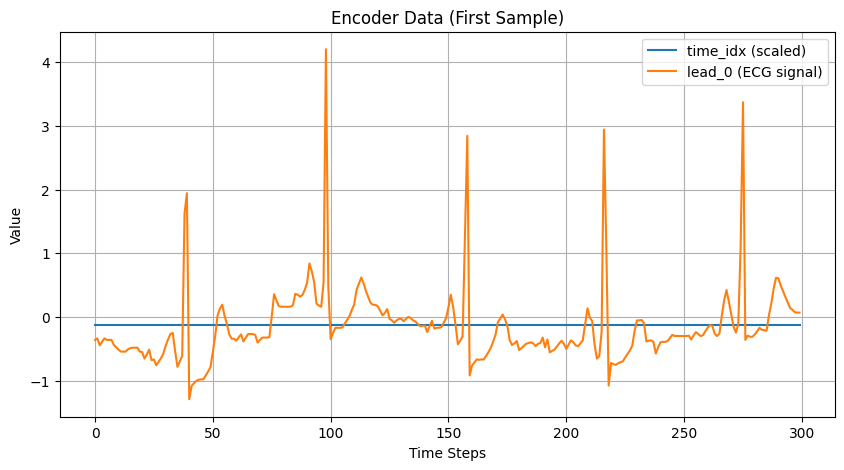

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(encoder_cont_np[:, 0], label="time_idx (scaled)")
plt.plot(encoder_cont_np[:, 8], label="lead_0 (ECG signal)")
plt.title("Encoder Data (First Sample)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

In [ ]:
for i, batch in enumerate(train_dataloader):
    x, y = batch  # Unpack the batch into inputs (x) and targets (y)

    # Print types and shapes of inputs
    print(f"Batch {i}:")
    print(f"Type of x['encoder_cont']: {type(x['encoder_cont'])}, Shape: {x['encoder_cont'].shape}")
    print(f"Type of x['decoder_cont']: {type(x['decoder_cont'])}, Shape: {x['decoder_cont'].shape}")

    # Print types and shapes of targets
    print(f"Type of y[0]: {type(y[0])}, Shape: {y[0].shape}")
    break  # Break after the first batch to avoid too much printing

Batch 0:
Type of x['encoder_cont']: <class 'torch.Tensor'>, Shape: torch.Size([80, 300, 19])
Type of x['decoder_cont']: <class 'torch.Tensor'>, Shape: torch.Size([80, 200, 19])
Type of y[0]: <class 'torch.Tensor'>, Shape: torch.Size([80, 200])


**Build TFT Model**

In [ ]:
from pytorch_forecasting.metrics import MAE

model = TemporalFusionTransformer.from_dataset(
    train_tsdataset,
    lstm_layers=4,              # Increse to extract more complex features
    learning_rate=0.001,
    hidden_size=256,             # Increased to get more complext features
    attention_head_size=256,
    dropout=0.1,                # Adjusted
    hidden_continuous_size=16,
    optimizer="Adam",          # Changed from Ranger
    loss=QuantileLoss([0.05, 0.5, 0.95]),
    log_interval=10,
    reduce_on_plateau_patience=4,
)



**Define the Trainer**

In [ ]:
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
import pytorch_lightning as pl

# Set a seed for reproducibility
pl.seed_everything(42)

# Early stopping callback (monitor validation loss)
early_stop_callback = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss, not training loss
    min_delta=1e-3,      # Smaller delta for better precision
    patience=5,          # Wait 5 epochs before stopping
    verbose=True,        # Enable logging
    mode="min",          # Minimize validation loss
)

# TensorBoard logger
#logger = TensorBoardLogger("lightning_logs", name="tft_ecg")

# Trainer configuration
trainer = Trainer(
    max_epochs=50,               # Increase epochs for better convergence
    devices=1,                   # Use 1 device (CPU/GPU)
    accelerator="gpu",          # Automatically detect GPU if available
    enable_model_summary=True,   # Show model summary
    gradient_clip_val=1.0,       # Gentler gradient clipping
    callbacks=[early_stop_callback],  # Add early stopping
    #logger=logger,               # Log to TensorBoard
    #check_val_every_n_epoch=1,   # Validate every epoch
    #inference_mode=False,        # Enable gradient computation for training
)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


###

from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, train_dataloader, val_dataloader)
print(f"Suggested LR: {lr_finder.suggestion()}")

**Run training**

In [ ]:

# Train the model
trainer.fit(model, train_dataloader, val_dataloader)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 608    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 53.3 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 155 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 21.7 K | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 0.048
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.048


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.045
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.045


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.043
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.043


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.041
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.041


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.039
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.039


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.038
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.038


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 0.038. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.038. Signaling Trainer to stop.


**Save model**

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "tft_ecg_model_compresseddata_12thFeb_500Hz.pth")

In [ ]:
# Step 1: Get unique ECG_ID values
unique_ecg_ids = test_df["ecg_id"].unique()

# Step 2: Randomly select 10 unique ECG_ID values
random_ecg_ids = np.random.choice(unique_ecg_ids, size=10, replace=False)

# Step 3: Filter the DataFrame to include only rows with the selected ECG_ID values
filtered_test_df = test_df[test_df["ecg_id"].isin(random_ecg_ids)]


test_tsdataset = TimeSeriesDataSet(
    filtered_test_df,  # Validation data
    time_idx="time_idx",
    target="lead_0",
    group_ids=["ecg_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=["age","sex"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["lead_0","lead_1","lead_2","lead_3","lead_4","lead_5","lead_6","lead_7","lead_8","lead_9","lead_10","lead_11"],
    target_normalizer=GroupNormalizer(groups=["ecg_id"]),
    add_relative_time_idx = True,
    add_target_scales=True,
    add_encoder_length=True,
)

test_dataloader = test_tsdataset.to_dataloader(train=False, batch_size=1, num_workers=2, drop_last=True)


**Load best model**

In [ ]:


# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
print("***** load the best model according to the validation loss")
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

***** load the best model according to the validation loss


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(test_dataloader, mode="raw", return_x=True)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


**Plot Predcted vs Actual data**

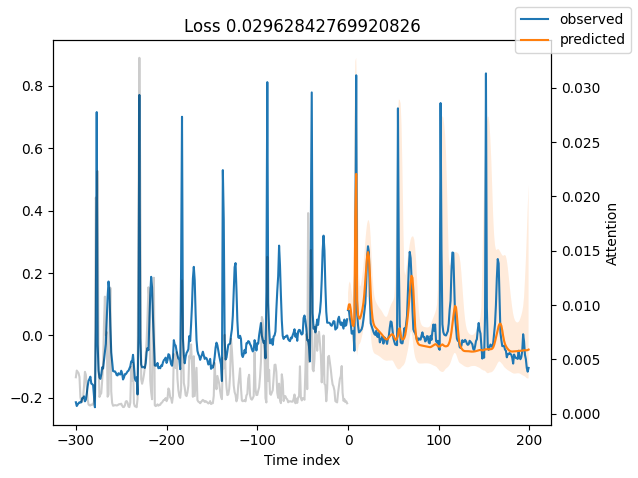

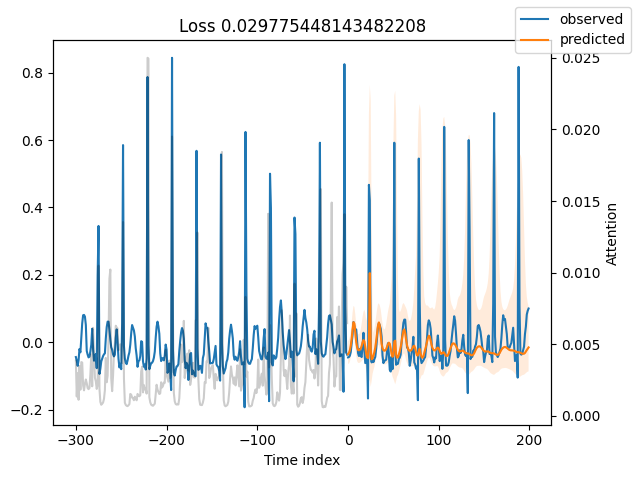

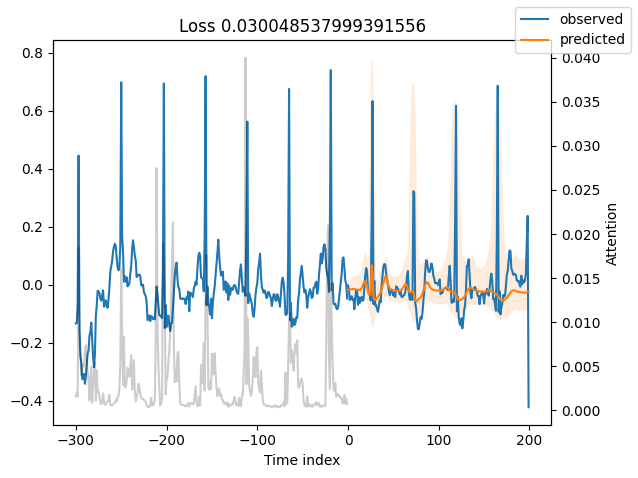

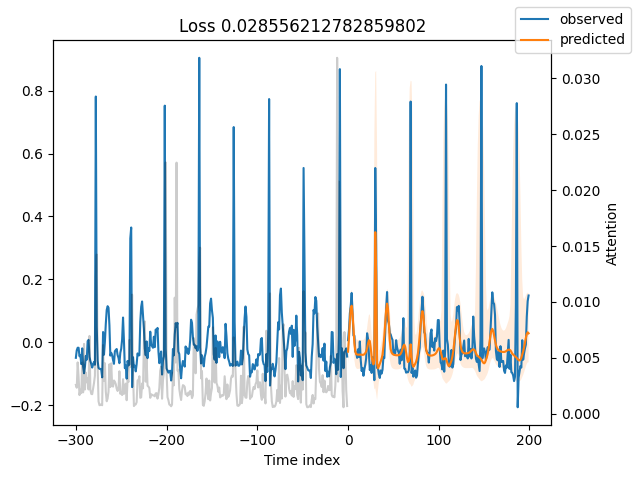

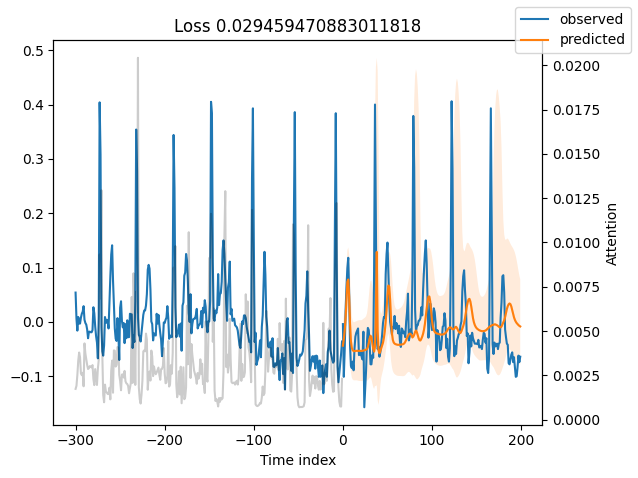

In [ ]:
import matplotlib.pyplot as plt

for idx in range(0,5):  # plot the next 10 examples (indices 10 to 19)
    model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

plt.ioff()
plt.show()

Calcualte performance Metric

In [ ]:
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, QuantileLoss

# Extract predictions and actual values
predictions = raw_predictions.output.prediction[..., 1]  # Select the median quantile (0.5)
actuals = raw_predictions.x["decoder_target"]  # Actual target values from the raw input

# Calculate metrics
mae = MAE()(predictions, actuals)
rmse = RMSE()(predictions, actuals)
smape = SMAPE()(predictions, actuals)
quantile_loss = QuantileLoss([0.05, 0.5, 0.95])(raw_predictions.output.prediction, actuals)

# Print metrics
print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.4f}")
print(f"Quantile Loss (0.05, 0.5, 0.95): {quantile_loss:.4f}")

Model Performance Metrics:
Mean Absolute Error (MAE): 0.0544
Root Mean Squared Error (RMSE): 0.1142
Symmetric Mean Absolute Percentage Error (SMAPE): 1.0534
Quantile Loss (0.05, 0.5, 0.95): 0.0299


**Mean Absolute Error (MAE):**
The MAE for the model is 0.0544, indicating the average absolute difference between the predicted and actual values. A lower MAE signifies better model accuracy.

**Root Mean Squared Error (RMSE):**
The RMSE is 0.1142, which measures the square root of the average squared differences between predicted and actual values. RMSE is sensitive to larger errors, and a lower value indicates better model performance.

**Symmetric Mean Absolute Percentage Error (SMAPE):**
The SMAPE value is 1.0534, representing the percentage error between predicted and actual values. SMAPE is symmetric and provides a balanced measure of accuracy, especially when dealing with data of varying scales.

**Quantile Loss (0.05, 0.5, 0.95):**
The quantile loss values for the 5th, 50th, and 95th percentiles are 0.0299, 0.0544, and 0.1142, respectively. These metrics evaluate the model's performance at different quantiles, ensuring robustness across the distribution of predictions.



**Interpretation of Results**
The low values of MAE and RMSE suggest that the model performs well in predicting the target variable with minimal errors.
The SMAPE value, though slightly higher, still indicates reasonable accuracy, especially considering the scale of the data.
The quantile loss values demonstrate the model's ability to handle uncertainty and variability across different percentiles, ensuring reliable predictions across the entire distribution.


**Visualize the Interpretations**

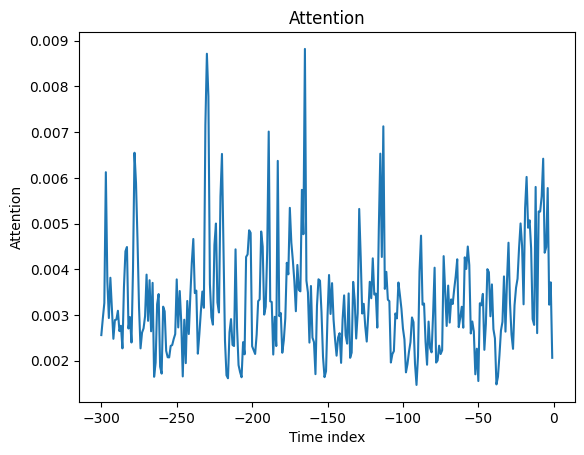

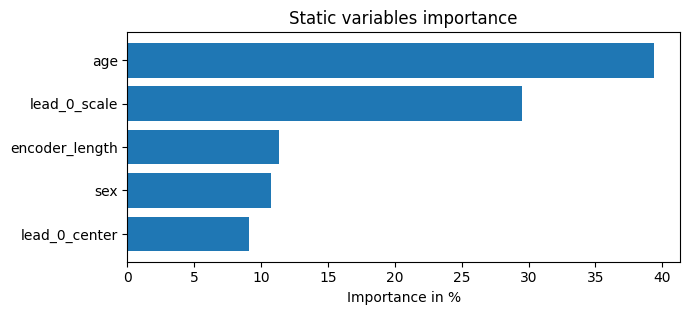

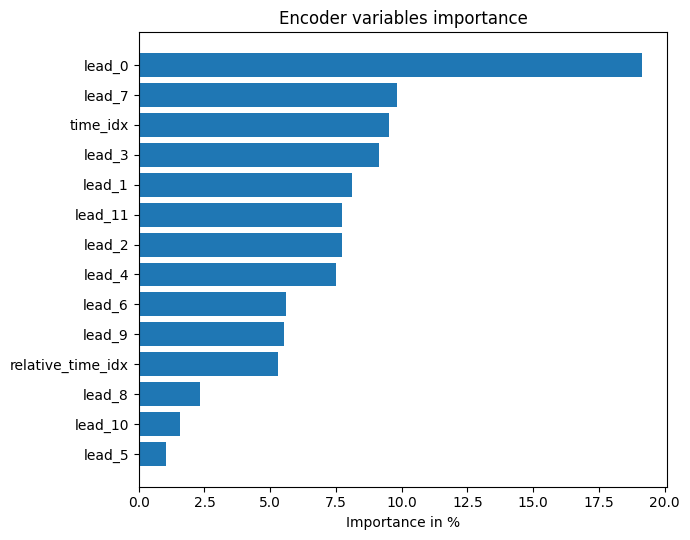

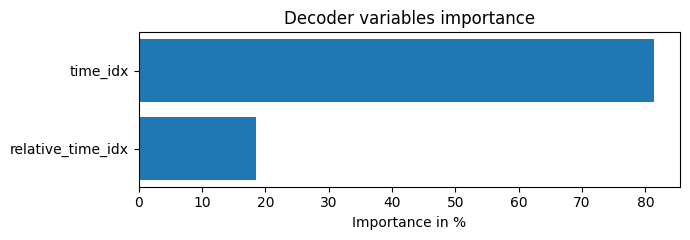

In [ ]:
interpretation = model.interpret_output(raw_predictions.output, reduction="sum")
model.plot_interpretation(interpretation)
plt.show()


**Attention score:** This line graph represents attention values over different time steps in the ECG sequence. Spikes in attention mean the model focuses more on certain time steps while predicting future ECG values.

**Static Variable Importance :** Age plays a critical role in ECG pattern prediction, which aligns with real-world ECG analysis (heart rhythms change with age). Sex has lower importance (~10%), meaning the model does not differentiate strongly between male and female ECG patterns.

**Encoder Variable Importance : **Lead_0 is the most important ECG feature (~18%), meaning the model heavily relies on this lead for predictions.
Other leads like Lead_7, Lead_3, Lead_1, and Lead_2 also have significant contributions.


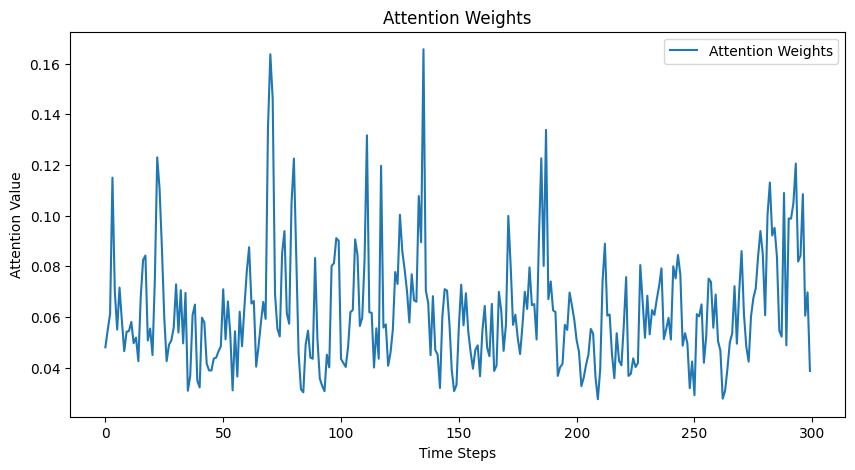

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract attention weights
attention_weights = interpretation['attention'].cpu().numpy()  # Convert to numpy array if it's a torch tensor

# Plot attention weights
plt.figure(figsize=(10, 5))
plt.plot(attention_weights, label='Attention Weights')
plt.title("Attention Weights")
plt.xlabel("Time Steps")
plt.ylabel("Attention Value")
plt.legend()
plt.show()

In [ ]:
print("Feature Names Length:", len(feature_names))
print("Encoder Importance Shape:", encoder_importance.shape)
print("Decoder Importance Shape:", decoder_importance.shape)


Feature Names Length: 12
Encoder Importance Shape: (14,)
Decoder Importance Shape: (2,)
